In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)
# import swifter

import spacy
from spacy.lang.en import English
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display, HTML
import warnings
# warnings.filterwarnings('ignore')

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [259]:


def decontracted(phrase):
    # specific
    # https://stackoverflow.com/a/47091370/4463701
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def replace_not_contractions(doc):
    """
    Passed as the callable to Pandas.apply()
    Replaces "n't" with " not"
    """
    if "n't" in doc:
        tokens = []
        for token in doc.split():
            if token.endswith("n't"):
                if token == "can't":
                    token = " can not "
                elif token == "won't":
                    token = " will not "
                else:
                    token = token.replace("n't", " not ")
            tokens.append(token)
        return ' '.join(tokens)  
    else:
        return doc

In [2]:
train_df, test_df = pd.read_csv('~/Tweet-Sentiment-Extraction-Data/train.csv').set_index('textID'),\
                    pd.read_csv('~/Tweet-Sentiment-Extraction-Data/test.csv').set_index('textID')

In [3]:
all_df = pd.concat([train_df, test_df], keys=['train', 'test'], 
                   names=['dataset'])\
                   .reset_index('dataset')


In [6]:
print(train_df.info())
print(test_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 27481 entries, cb774db0d1 to 6f7127d9d7
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           27480 non-null  object
 1   selected_text  27480 non-null  object
 2   sentiment      27481 non-null  object
dtypes: object(3)
memory usage: 858.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 3534 entries, f87dea47db to 469e15c5a8
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3534 non-null   object
 1   sentiment  3534 non-null   object
dtypes: object(2)
memory usage: 82.8+ KB
None


# Selected Text Analysis

## Word Counts

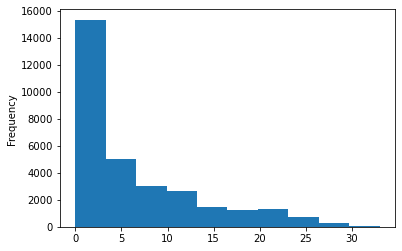

In [37]:
all_df.selected_text.fillna('').str.split().str.len().plot.hist()

In [34]:
all_df[all_df.selected_text.fillna('').str.split().str.len() > 25]

,dataset,text,selected_text,sentiment
textID,,,,
a6c61eac26,train,she is good! so gor-juz yea i kno i asked her yesterday when we were at tha hospital if she talked to u and she said no,she is good! so gor-juz yea i kno i asked her yesterday when we were at tha hospital if she talked to u and she said no,neutral
94bd67443c,train,OK - I`m out of here for now. Just popped in to say Hi and check on things. I`ll probably head to the guttah later on tonight,OK - I`m out of here for now. Just popped in to say Hi and check on things. I`ll probably head to the guttah later on tonight,neutral
0c0563423e,train,Miles from you I`m in Essex so give me plenty of warning so I can arrive in time to get at least one of those free beers.,Miles from you I`m in Essex so give me plenty of warning so I can arrive in time to get at least one of those free beers,neutral
cd0d522bb1,train,"His snoring is so annoying n it keeps me from sleeping (like right now, lol) but I honestly wud miss it if it eva left I love him.","His snoring is so annoying n it keeps me from sleeping (like right now, lol) but I honestly wud miss it if it eva left I love him.",neutral
3e67a75303,train,Today is going to be a normal day for I hope. We had a group of pilots from a large airline come in last night so it was too much drink,Today is going to be a normal day for I hope. We had a group of pilots from a large airline come in last night so it was too much drink,neutral
...,...,...,...,...
c0da406e23,train,samee well i aint a man i am a girl obv nd i am 14 lol i aint no1 special or not famous or rich wish to be tho ****,samee well i aint a man i am a girl obv nd i am 14 lol i aint no1 special or not famous or rich wish to be tho,neutral
d370238b6b,train,just saw an advert for ATTICS TO EDEN on tv out today and only ï¿½9.99 from HMV...so I`m not sure why I had to pay ï¿½13 at HMV...never mind,just saw an advert for ATTICS TO EDEN on tv out today and only ï¿½9.99 from HMV...so I`m not sure why I had to pay ï¿½13 at HMV...never mind,neutral
326afaf347,train,think 2 to start off with but a house that can fit 4 - or we may go the whole hog and get 4.... not sure yet,think 2 to start off with but a house that can fit 4 - or we may go the whole hog and get 4.... not sure yet,neutral


## Unique Characters

In [75]:
unique_characters = sorted(set(train_df.selected_text.fillna('').sum()))

''.join(unique_characters)

" !#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~½¿ï"

In [70]:
train_df[train_df.selected_text.fillna('').str.contains('{')]

,text,selected_text,sentiment
textID,,,
a10e8911e9,if aint Bee then it aint me...ya heard me? {this for u keemie},if aint Bee then it aint me...ya heard me? {this for u keemie},neutral
6a820dfeec,I HATE FLORISTS No rose for cassadee tomorrow now =/ fricken **** florist people ={ hmm..need something else...hmm...,I HATE FLORISTS No rose for cassadee tomorrow now =/ fricken **** florist people ={ hmm..need something else...hmm...,negative
abfb47f0b8,i have nothing to do except right a eassy due on monday D: :[ :{ ]: }:,i have nothing to do except right a eassy due on monday D: :[ :{ ]: }:,negative
d0b0559549,gnite Fukn Nite * wanted sum {pinga} but couldn`t get any,gnite Fukn Nite * wanted sum {pinga} but couldn`t get any,neutral


In [84]:
print(train_df.loc[['d0b0559549', 'abfb47f0b8']].selected_text)

train_df.loc[['d0b0559549', 'abfb47f0b8']].selected_text.str.split('\s\W')

textID
d0b0559549    gnite  Fukn Nite * wanted sum {pinga} but couldn`t get any             
abfb47f0b8    i have nothing to do except right a eassy due on monday D: :[ :{  ]: }:
Name: selected_text, dtype: object


textID
d0b0559549    [gnite, Fukn Nite,  wanted sum, pinga} but couldn`t get any]             
abfb47f0b8    [i have nothing to do except right a eassy due on monday D:, [, {, ]:, :]
Name: selected_text, dtype: object

In [114]:
train_df.loc[['d0b0559549']].selected_text[0].lower().split() == train_df.loc[['d0b0559549']].selected_text.str.lower().str.split()[0]
# train_df.loc[['d0b0559549']].selected_text.to_string()

True

In [116]:
str(train_df.loc[['d0b0559549']].selected_text[0]).lower().split()

['gnite',
 'fukn',
 'nite',
 '*',
 'wanted',
 'sum',
 '{pinga}',
 'but',
 'couldn`t',
 'get',
 'any']

# Text Analysis

In [38]:
all_df.text.fillna('').str.split().str.len().describe()

count    31015.000000
mean     12.886539   
std      6.924092    
min      0.000000    
25%      7.000000    
50%      12.000000   
75%      18.000000   
max      33.000000   
Name: text, dtype: float64

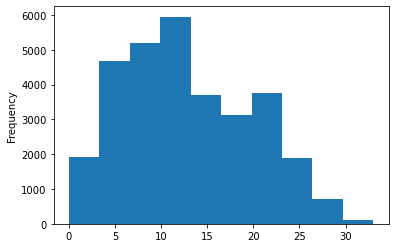

In [36]:
all_df.text.fillna('').str.split().str.len().plot.hist()

In [41]:
all_df[all_df.text.fillna('').str.split().str.len() == 30]

,dataset,text,selected_text,sentiment
textID,,,,
90a2cdb657,train,What better way to spoil mum than to let her kick back and relax over a nice meal and a bottle of her favorite wine? Our wine was a red,favorite,positive
da724fbf5e,train,_xo hey chick u alryt u at dads tmoro we sud do sumin aen like last week we neva dun oot this week lol missed you ha bye hun ****,missed,negative
881aeb2f99,train,"Off to the shelters around me to look for her. I hope she is okay, so afraid that she is going to get hit by a car. Can`t stop crying","Off to the shelters around me to look for her. I hope she is okay, so afraid that she is going to get hit by a car. Can`t stop crying",neutral
b31486f8c0,train,How did Day 26 go from a good budget video (imma put it on her) to such a low budget video (Stadium Music) The end may be near for them,such a low budget video,negative
98e7195247,train,soooo sunburnt my mum was out earlier so i had to wait for her to get in and fell asleep on the trampoline for 2 hours in the sun (U),sunburnt,negative
...,...,...,...,...
c99820b355,test,O.k i feel like i need to cry now i can`t believe that in less than 2 years ill be walking across the stage to get a High School diploma!,NaN,neutral
470f2669c4,test,well being a retired drummer I can do my own drum roll so all you need to do is read my posts since they take a ton of time lol,NaN,neutral
3c9419868b,test,"staying afterschool today not that i have any 'friends' on here - but if i did , i`d tell `em to text me ! lol [ likin` us <3 ]",NaN,positive


# Sentiment Frequency

In [98]:
sentiment_counts_train, sentiment_counts_test =\
    train_df.groupby('sentiment').size().sort_values(ascending=False),\
    test_df.groupby('sentiment').size().sort_values(ascending=False)


fig = go.Figure(data=[
    go.Bar(name='train', x=sentiment_counts_train.index, y=sentiment_counts_train),
    go.Bar(name='test', x=sentiment_counts_test.index, y=sentiment_counts_test)
]).update_layout(barmode='stack', 
                 title='Sentiment Counts by Train & Test Sets')

fig.show()

In [255]:

nlp = English()

all_text = all_df.text.fillna('')\
    .str.lower()\
    .apply(lambda text: ' '.join([tok.lemma_ for tok in nlp(text) if not tok.is_punct and not tok.is_space and not tok.like_url]))\
    .apply(lambda text: ' '.join([tok.text for tok in nlp(text) if not tok.is_stop]))

In [261]:

def create_n_gram_dtm(text_data, min_n_gram=1, max_n_gram=1, min_df=.01):
    """
    Creates a document-term-matrix from a column of text
    :param text_data: a Pandas Series containing text
    :param max_n_gram: default is 1
    :param min_n_gram: default is 1
    :param min_df: default is 10
    :return: dtm sparse matrix and list of feature names
    """
    n_gram_vectorizer = TfidfVectorizer(min_df=min_df,
                                        ngram_range=(min_n_gram, max_n_gram))   
    dtm = n_gram_vectorizer.fit_transform(text_data)
    return (dtm, n_gram_vectorizer.get_feature_names())


unigram_dtm, unigram_feature_names = create_n_gram_dtm(all_text,
                                                       min_df=10**(-3))

In [267]:

def plot_most_correlated_tokens(dtm, feature_names, labels, n_grams = 1, 
                                top_n_tokens = 10, return_df=False):
    """
    Calculates the chi-squared statistic for each of terms and classes 
    and plots the top 10 terms by class.
    
    :param dtm: a sparse matrix
    :param feature_names: list of feature names
    :param n_grams: select the n-gram
    :param labels: list of response labels for each document
    :param top_n_tokens: select the top n
    :return: returns df if return_df=True
    Sources: https://github.com/mwaskom/seaborn/issues/867#issuecomment-184918644
    """
    # initialize empty df
    response_label_values = labels.unique()
    top_chi2_df = pd.DataFrame(columns=['stars', 'feature_name', 'chi2_value'])
    for response_label_value in response_label_values:   
        features_chi2 = chi2(dtm, labels==response_label_value) # calc chi^2 for the class
        indices = np.argsort(features_chi2[0]) # get the sorted indices
        feature_names_sorted = np.array(feature_names)[indices] # sort feature names ascendinglyly    
        top_feature_names = feature_names_sorted[-top_n_tokens:]
        top_chi2_values = np.sort(features_chi2[0])[-top_n_tokens:]
        stars_df = pd.DataFrame({'stars': np.repeat(response_label_value, top_n_tokens), 
                                 'feature_name': top_feature_names,
                                 'chi2_value': top_chi2_values})   
        top_chi2_df = pd.concat([top_chi2_df, stars_df], sort=True)

    # create Faceted Grid Plot
    g = sns.FacetGrid(col="stars", col_wrap=3, sharex=False, margin_titles=True, data=top_chi2_df)
    g.map(sns.barplot, "feature_name", "chi2_value", color="steelblue")
    [plt.setp(ax.get_xticklabels(), rotation=45, fontsize=15) for ax in g.axes.flat]
    sns.set(font_scale=2)
    plt.subplots_adjust(hspace=.75, wspace=.3) # https://stackoverflow.com/a/43699744/4463701
    g.fig.set_size_inches(20,15) # https://stackoverflow.com/a/46346780/4463701
    if return_df:
        return top_chi2_df
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
# https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/feature_selection/univariate_selection.py#L172

C:\Users\kyleg\Anaconda3\envs\py38\lib\site-packages\seaborn\axisgrid.py:728: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



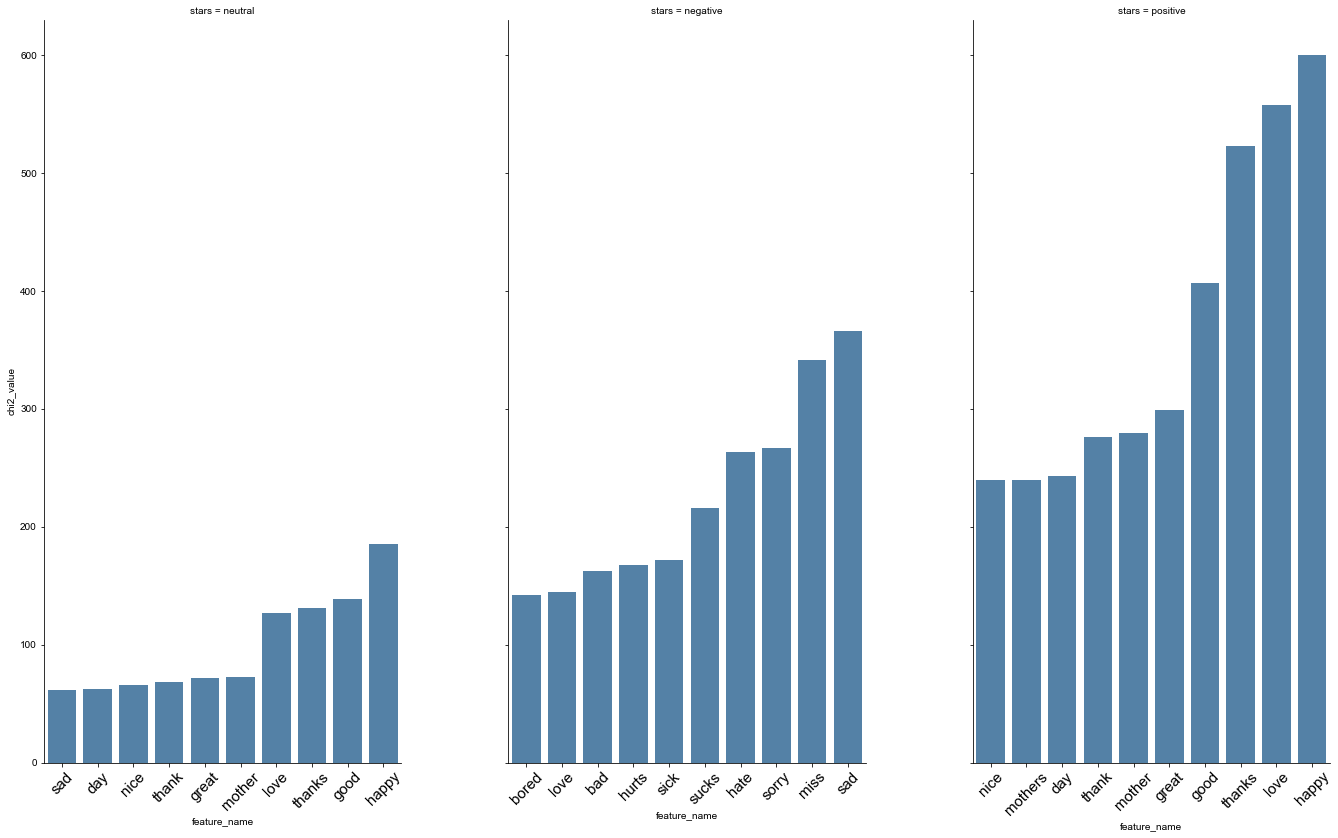

In [268]:
plot_most_correlated_tokens(unigram_dtm, unigram_feature_names, all_df.sentiment)

In [282]:
len(set(train_df.selected_text.fillna('').str.lower().str.cat(sep=' ').split()))

28686

In [281]:
train_df.selected_text.isnull().sum()

1

In [299]:
pd.Series(train_df.selected_text.fillna('').str.lower().str.cat(sep=' ').split(), dtype='category')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)